In [8]:
import numpy as np

import matplotlib.pyplot as plt

# A Tale of Two Time Scales: Determining Integrated Volatility With Noisy High-Frequency Data

This notebook aims to reproduce some of the results of the Monte-Carlo simulation of the paper from Lan Zhang, Per A. Mykland, and Yacine Ait-Sahalia.

In [9]:
# Setting global variables
S0 = 100.0  # Initial asset price
v0 = 0.04   # Initial volatility

# Parameters proposed by the paper
mu = .05
kappa = 5
alpha = .04
gamma = .5
rho = -.5
T = 1/252
Nsec = int(6.5 * 3600)
dt = T / Nsec

# Setting number of simulations
N_simulations = 5000

# Heston's volatility model

In [10]:
def generate_brownians():
    ''' Generates pairs of Brownian motions with correlation rho
    '''
    dB = np.random.normal(0, np.sqrt(dt), (N_simulations, Nsec))
    dW = rho * dB + np.sqrt(1-rho**2) * np.random.normal(0, np.sqrt(dt), (N_simulations,Nsec))
    
    return dB, dW

def generate_returns():
    ''' Generates the returns under the Heston volatility model
    '''
    X = np.zeros((N_simulations, Nsec))
    v = np.zeros((N_simulations, Nsec+1))

    dB, dW = generate_brownians()
    
    # Computing evolution of square of volatility
    v[:,0] = v0
    for i in range(Nsec):
        v[:,i+1] = v[:,i] + kappa * (alpha - v[:,i]) * dt + gamma * np.sqrt(v[:,i]) * dW[:,i]

    # Computing evolution of returns
    dX = (mu - v[:,1:]/2) * dt + np.sqrt(v[:,1:]) * dB
    X = dX.cumsum(axis = 1)
    
    return dX, X

# Visualizing returns

In [11]:
dX, X = generate_returns()

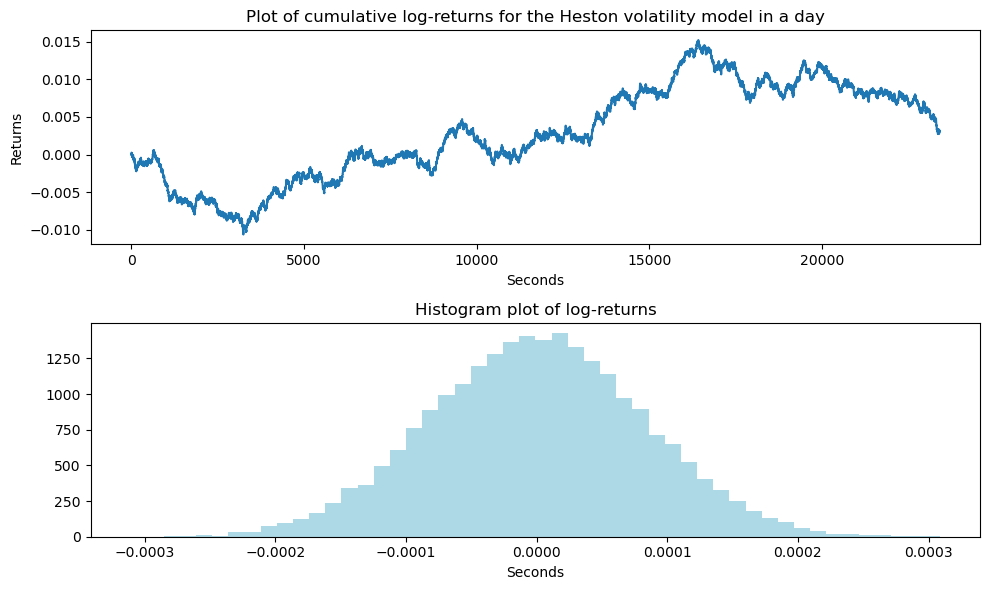

In [12]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# First subplot: Plot of cumulative log-returns
axes[0].plot(np.arange(Nsec), X[0, :])
axes[0].set_title("Plot of cumulative log-returns for the Heston volatility model in a day")
axes[0].set_ylabel('Returns')
axes[0].set_xlabel('Seconds')

# Second subplot: Histogram plot of log-returns
axes[1].hist(dX[0, :], bins=50, color='lightblue')
axes[1].set_title('Histogram plot of log-returns')
axes[1].set_xlabel('Seconds')

# Adjust spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()

# Implementing estimators

In [13]:
def get_Y(X: np.array) -> np.array:
    ''' Returns the Y with the noise from market microstructure
    '''
    nrows, ncols = X.shape
    noise = np.random.normal(0, np.sqrt(0.0005), (nrows, ncols))
    return X + noise

def get_e2(Y: np.array) -> np.array:
    ''' Returns E[eps^2]
    '''
    return (1/(2*Nsec)) * fifth_best_estimator(Y)

def get_e4(Y: np.array) -> np.array:
    ''' Returns E[eps^4]
    '''
    return (1/(2*Nsec)) * np.sum(np.power(Y.diff(Y, axis = 1), 4) - 3 * np.square(e2), axis = 1)

def true_volatility(dX: np.array) -> float:
    ''' Returns the true volatility
    '''
    return np.square(dX).sum(axis = 1)

def fifth_best_estimator(Y: np.array) -> float:
    ''' Implements the fifth best estimator. It simply compute the sum
    of the squares of the log returns.
    '''
    dY = np.diff(Y, axis = 1)
    return np.square(dY).sum(axis = 1)

def fourth_best_estimator(Y: np.array, n_sparse: int) -> float:
    ''' Same as fifth but samples sparsely on the log returns
    '''
    dY = np.diff(Y, axis = 1)
    step = Nsec // n_sparse
    
    return np.square(dY[:,::step]).sum(axis = 1)
    
def third_best_estimator(Y: np.array) -> float:
    ''' Applies the fourth best estimator using the best step
    Estimation of noise is discussed in page 5 of the paper.
    '''
    e2 = get_e2(Y)
    e4 = get_e4(Y)
    n_sparse_optimal = ((T/4)*(e4/e2**2))**(1/3)
    
    return fourth_best_estimator(Y, n_sparse_optimal)

def second_best_estimator(Y: np.array, K: int = 0) -> float:
    ''' Split the data in K grids, with each one being composed of 
    i, i+K, i+2K, ... i going from 1 to K.
    If no value of K is passed the optimal value is computed.
    '''

    # Computes optimal K if no value is passed
    if K == 0:
        e2 = get_e2(Y)
        e4 = get_e4(Y)
        n_star = (T/(6*e2**2)*e4)**(1/3)
        
        K = Nsec / n_star
             
    estimator = 0    
    for i in range(K):
        estimator += np.square(np.diff(Y[i::K])).sum()
    estimator /= K
    
    return estimator

def best_estimator(Y: np.array) -> float:
    '''Implements best estimator proposed by the paper
    '''
    
    e2 = get_e2(Y)
    e4 = get_e4(Y)
    
    c_star = ((T/12) * e4 / e2**2)**(1/3)
    K_star = c_star * Nsec**(2/3)
    
    n_bar =  Nsec / K_star
    
    return second_best_estimator(Y, K_star) - (n_bar / Nsec) * fifth_best_estimator(Y)

## Visualizing true volatility 

In [14]:
vol = true_volatility(dX[0,:])

plt.hist(dX[0, :], bins=50, color='lightblue')
plt.title('Histogram plot of log-returns with true volatility range')
plt.xlabel('Seconds')
plt.axvline(-vol)
plt.axvline(vol)
plt.show()

AxisError: axis 1 is out of bounds for array of dimension 1

## Visualizing the estimators